# Hidden Markov Models (HMM) Tutorial with Sequenzo - MVAD Dataset

This tutorial will guide you step-by-step through using Hidden Markov Models (HMM) for sequence analysis using the Sequenzo package. We'll use the `mvad` dataset to analyze education and employment sequences.

This tutorial corresponds to the R seqHMM tutorial, allowing you to compare results step-by-step to verify consistency between the R and Python implementations.

## What are Hidden Markov Models?

Hidden Markov Models (HMMs) are statistical models that help us understand sequences of observations by assuming there are **hidden underlying states** that generate these observations.

### Key Concepts:
- **Hidden States**: The underlying states you can't directly observe (e.g., "stable career", "transitioning", "exploring")
- **Observations**: What you actually see in your data (e.g., "employed", "unemployed", "student")
- **Transitions**: How likely you are to move from one hidden state to another
- **Emissions**: How likely each hidden state is to produce each observation

In this tutorial, we'll:
1. Load and prepare the mvad dataset
2. Build an HMM model (matching R's seqHMM approach)
3. Fit the model to discover hidden patterns
4. Make predictions about hidden states
5. Visualize the model
6. Compare different models
7. Explore Mixture HMM (clustering sequences)

## Step 1: Import Libraries and Load Data

First, let's import the necessary libraries and load our dataset.

In [1]:
# Import Sequenzo and other necessary libraries
from sequenzo import SequenceData, load_dataset
from sequenzo.seqhmm import (
    build_hmm, fit_model, predict, posterior_probs, plot_hmm,
    build_mhmm, fit_mhmm, predict_mhmm, plot_mhmm,
    aic, bic, compare_models
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility (matching R's set.seed(21))
np.random.seed(21)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the mvad dataset
# This dataset contains education and employment sequences over 72 months
# Note: The R code uses columns 15:86 (1-indexed), which is columns 14:86 (0-indexed) in Python
df = load_dataset('mvad')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few columns: {list(df.columns[:15])}")
print(f"\nNumber of sequences: {len(df)}")

# The time columns start from index 14 (column 15 in R, which is 1-indexed)
# These are date columns like 'Jul.93', 'Aug.93', etc.
print(f"\nTime columns (starting from index 14):")
print(f"First time column: {df.columns[14]}")
print(f"Last time column: {df.columns[-1]}")
print(f"Number of time columns: {len(df.columns) - 14}")

df.head()

Dataset shape: (712, 86)

First few columns: ['id', 'weight', 'male', 'catholic', 'Belfast', 'N.Eastern', 'Southern', 'S.Eastern', 'Western', 'Grammar', 'funemp', 'gcse5eq', 'fmpr', 'livboth', 'Jul.93']

Number of sequences: 712

Time columns (starting from index 14):
First time column: Jul.93
Last time column: Jun.99
Number of time columns: 72


,id,weight,male,catholic,Belfast,N.Eastern,Southern,S.Eastern,Western,Grammar,...,Sep.98,Oct.98,Nov.98,Dec.98,Jan.99,Feb.99,Mar.99,Apr.99,May.99,Jun.99
0,1,0.33,no,no,no,no,no,no,yes,no,...,employment,employment,employment,employment,employment,employment,employment,employment,employment,employment
1,2,0.57,no,no,no,no,no,no,yes,no,...,HE,HE,HE,HE,HE,HE,HE,HE,HE,HE
2,3,1.59,yes,yes,no,no,no,no,yes,no,...,employment,employment,employment,employment,employment,employment,employment,employment,joblessness,joblessness
3,4,1.59,no,no,no,no,no,no,yes,no,...,employment,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness,joblessness
4,5,0.57,yes,no,no,no,no,no,yes,no,...,HE,HE,HE,HE,HE,HE,HE,HE,HE,HE


## Step 2: Prepare Sequence Data

Now we need to convert our dataframe into a `SequenceData` object that Sequenzo can work with. The mvad dataset has:

- 72 time points (from Jul.93 to Jun.99, which is 72 months)
- 6 states representing different education/employment situations
- Sequence data in columns 14-85 (0-indexed, matching R's 15:86)
- Column names are date strings like 'Jul.93', 'Aug.93', etc.

**Note**: We do NOT use weighted data (as requested - no weighted data)

In [3]:
# Define time points (columns 15:86 in R, which is 14:86 in 0-indexed Python)
# R uses columns 15:86, which in Python DataFrame would be index 14:86
# The actual column names are date strings like 'Jul.93', 'Aug.93', etc.
# We need to use the actual column names from the DataFrame
time_list = df.columns[14:86].tolist()  # 72 time points (from Jul.93 to Jun.99)

print(f"Time columns: {len(time_list)} columns")
print(f"First time column: {time_list[0]}")
print(f"Last time column: {time_list[-1]}")

# Define the 6 states (matching R's mvad_alphabet)
# Note: We need to check what actual values are in the data
# Let's first see what unique values exist in the time columns
unique_values = set()
for col in time_list:
    unique_values.update(df[col].unique())
print(f"\nUnique values in time columns: {sorted(unique_values)}")

# Define the 6 states (matching R's mvad_alphabet)
states = ['employment', 'FE', 'HE', 'joblessness', 'school', 'training']

# Define human-readable labels (matching R's mvad_labels)
labels = [
    "employment",
    "further education",
    "higher education",
    "joblessness",
    "school",
    "training"
]

# Create SequenceData object
# Note: We do NOT use weights (as requested - no weighted data)
sequence_data = SequenceData(
    df,
    time=time_list,
    id_col='id',
    states=states,
    labels=labels,
    # weights=None  # Explicitly not using weights
)

print("\nSequenceData created successfully!")
print(f"Number of sequences: {len(sequence_data.sequences)}")
print(f"Number of states: {len(sequence_data.states)}")
print(f"States: {sequence_data.states}")

Time columns: 72 columns
First time column: Jul.93
Last time column: Jun.99

Unique values in time columns: ['FE', 'HE', 'employment', 'joblessness', 'school', 'training']

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 712
[>] Number of time points: 72
[>] Min/Max sequence length: 72 / 72
[>] States: ['employment', 'FE', 'HE', 'joblessness', 'school', 'training']
[>] Labels: ['employment', 'further education', 'higher education', 'joblessness', 'school', 'training']
[>] Weights: Not provided

SequenceData created successfully!
Number of sequences: 712
Number of states: 6
States: ['employment', 'FE', 'HE', 'joblessness', 'school', 'training']


## Step 3: Build an HMM Model (Matching R's seqHMM)

Now we'll create an HMM model following the **exact same** approach as the R seqHMM package. In the R code, they use:

- 5 hidden states
- Custom initial probabilities: `c(0.2, 0.2, 0.2, 0.2, 0.2)`
- Custom transition matrix: diagonal = 0.9, off-diagonal = 0.025
- Custom emission matrix with specific patterns

**Important**: We need to use the **exact same initial values** as R to ensure consistent results. Let's build a model with the same initialization:

In [4]:
# Build an HMM model with 5 hidden states (matching R's approach EXACTLY)
# The R code uses custom initial values, so we need to match them exactly

# Define initial state probabilities (matching R: c(0.2, 0.2, 0.2, 0.2, 0.2))
initial_probs = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# Define transition matrix (matching R: diagonal = 0.9, off-diagonal = 0.025)
# R code: trans <- matrix(0.025, 5, 5); diag(trans) <- 0.9
trans = np.full((5, 5), 0.025)
np.fill_diagonal(trans, 0.9)

# Define emission matrix (matching R's exact values)
# R code uses this order: employment, FE, HE, joblessness, school, training
# States order in our data: ['employment', 'FE', 'HE', 'joblessness', 'school', 'training']
# R emission matrix (by row):
# Row 1: SC (school) - [0.05, 0.05, 0.05, 0.05, 0.75, 0.05]
# Row 2: FE (further education) - [0.05, 0.75, 0.05, 0.05, 0.05, 0.05]
# Row 3: JL, TR (joblessness, training) - [0.05, 0.05, 0.05, 0.4, 0.05, 0.4]
# Row 4: HE (higher education) - [0.05, 0.05, 0.75, 0.05, 0.05, 0.05]
# Row 5: EM (employment) - [0.75, 0.05, 0.05, 0.05, 0.05, 0.05]
emiss = np.array([
    [0.05, 0.05, 0.05, 0.05, 0.75, 0.05],  # Hidden state 1: High prob for school
    [0.05, 0.75, 0.05, 0.05, 0.05, 0.05],  # Hidden state 2: High prob for FE
    [0.05, 0.05, 0.05, 0.4,  0.05, 0.4],   # Hidden state 3: High prob for joblessness & training
    [0.05, 0.05, 0.75, 0.05, 0.05, 0.05],  # Hidden state 4: High prob for HE
    [0.75, 0.05, 0.05, 0.05, 0.05, 0.05]   # Hidden state 5: High prob for employment
])

# Verify the order of states matches
print("State order in sequence_data:", sequence_data.states)
print("Expected order: ['employment', 'FE', 'HE', 'joblessness', 'school', 'training']")
print("\nEmission matrix columns should match this order!")

# Build HMM with custom initial values (matching R exactly)
hmm = build_hmm(
    sequence_data,
    initial_probs=initial_probs,
    transition_probs=trans,
    emission_probs=emiss,
    random_state=21  # Matching R's set.seed(21)
)

print("\nHMM model created!")
print(f"Number of hidden states: {hmm.n_states}")
print(f"Number of observed states: {hmm.n_symbols}")

print(f"\nInitial state probabilities (matching R):")
print(hmm.initial_probs)

print(f"\nTransition matrix (matching R: diagonal=0.9, off-diagonal=0.025):")
print(hmm.transition_probs)

print(f"\nEmission matrix (first 3 rows, matching R):")
print(hmm.emission_probs[:3, :])

State order in sequence_data: ['employment', 'FE', 'HE', 'joblessness', 'school', 'training']
Expected order: ['employment', 'FE', 'HE', 'joblessness', 'school', 'training']

Emission matrix columns should match this order!

HMM model created!
Number of hidden states: 5
Number of observed states: 6

Initial state probabilities (matching R):
[0.2 0.2 0.2 0.2 0.2]

Transition matrix (matching R: diagonal=0.9, off-diagonal=0.025):
[[0.9   0.025 0.025 0.025 0.025]
 [0.025 0.9   0.025 0.025 0.025]
 [0.025 0.025 0.9   0.025 0.025]
 [0.025 0.025 0.025 0.9   0.025]
 [0.025 0.025 0.025 0.025 0.9  ]]

Emission matrix (first 3 rows, matching R):
[[0.05 0.05 0.05 0.05 0.75 0.05]
 [0.05 0.75 0.05 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.4  0.05 0.4 ]]


## Step 4: Fit the Model

Now we'll fit the model to our data using the EM (Expectation-Maximization) algorithm. The R code uses:

```r
fit_hmm_mvad <- fit_model(
  init_hmm_mvad, 
  control_em = list(restart = list(times = 100))
)
```

This will:
1. Estimate the transition probabilities between hidden states
2. Estimate the emission probabilities (which observed states each hidden state produces)
3. Find the best parameters that explain our sequence data

In [5]:
# Fit the model to the data
# The R code uses restart = list(times = 100) for multiple random restarts
# We'll use a reasonable number of iterations and tolerance

hmm = fit_model(
    hmm,
    n_iter=100,  # Maximum number of iterations
    tol=1e-2,    # Convergence tolerance
    verbose=True  # Print progress
)

print("\nModel fitting completed!")
print(f"Log-likelihood: {hmm.log_likelihood:.2f}")
print(f"Number of iterations: {hmm.n_iter}")
print(f"Converged: {hmm.converged}")

[notice] A new release of sequenzo is available: 0.1.22 -> 0.1.24
[notice] To update, run: pip install --upgrade sequenzo



Model fitting completed!
Log-likelihood: -16426.17
Number of iterations: 13
Converged: True


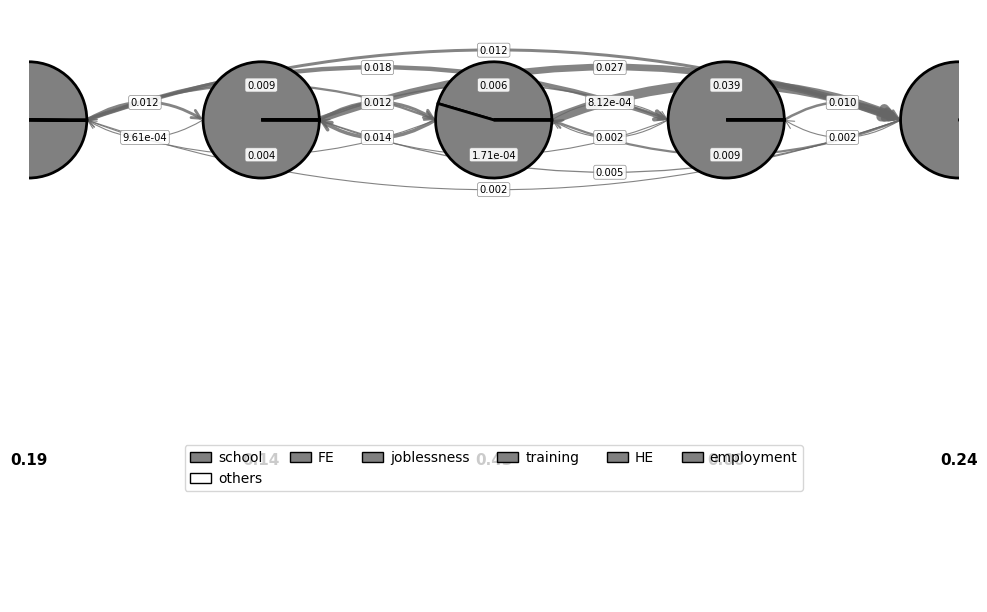

In [6]:
# Plot the HMM as a network graph (similar to R's plot.hmm)
# This creates a directed graph with pie chart nodes showing emission probabilities
# and arrows showing transition probabilities between states

plot_hmm(hmm, 
         which='network',           # Use 'network' to create the graph visualization
         vertex_size=50,            # Size of the nodes (pie charts)
         vertex_label_dist=1.5,     # Distance of labels from node centers
         edge_curved=0.5,           # Curvature of edges (arrows) - makes the graph easier to read
         edge_label_cex=0.8,        # Size of edge labels (transition probabilities)
         with_legend='bottom')      # Show legend at the bottom

plt.tight_layout()
plt.show()

## Step 5: Examine the Fitted Model Parameters

Let's look at what the model learned about the hidden states. This helps us understand what patterns the model discovered.


In [8]:
# Initial state probabilities
# These tell us how likely each hidden state is at the start of a sequence

# Check if hmm is defined (from previous cells)
if 'hmm' not in locals() and 'hmm' not in globals():
    raise NameError(
        "Variable 'hmm' is not defined. Please run the previous cells first:\n"
        "1. The cell that calls build_hmm() to create the HMM model\n"
        "2. The cell that calls fit_model() to fit the model"
    )

print("Initial State Probabilities:")
print("=" * 50)
for i, prob in enumerate(hmm.initial_probs):
    print(f"Hidden State {i+1}: {prob:.4f} ({prob*100:.2f}%)")

# Transition probabilities
# These tell us how likely transitions are between hidden states
print("\nTransition Probabilities (rows = from, columns = to):")
print("=" * 50)
transition_df = pd.DataFrame(
    hmm.transition_probs,
    index=[f"State {i+1}" for i in range(hmm.n_states)],
    columns=[f"State {j+1}" for j in range(hmm.n_states)]
)
print(transition_df.round(3))

# Emission probabilities
# These tell us which observed states each hidden state is likely to produce
print("\nEmission Probabilities (rows = hidden states, columns = observed states):")
print("=" * 50)
emission_df = pd.DataFrame(
    hmm.emission_probs,
    index=[f"Hidden State {i+1}" for i in range(hmm.n_states)],
    columns=[f"Observed: {labels[i]}" for i in range(len(labels))]
)
print(emission_df.round(3))

Initial State Probabilities:
Hidden State 1: 0.1897 (18.97%)
Hidden State 2: 0.1363 (13.63%)
Hidden State 3: 0.4312 (43.12%)
Hidden State 4: 0.0000 (0.00%)
Hidden State 5: 0.2428 (24.28%)

Transition Probabilities (rows = from, columns = to):
         State 1  State 2  State 3  State 4  State 5
State 1    0.949    0.012    0.009    0.018    0.012
State 2    0.001    0.953    0.012    0.006    0.027
State 3    0.004    0.014    0.941    0.001    0.039
State 4    0.000    0.000    0.002    0.987    0.010
State 5    0.002    0.005    0.009    0.002    0.982

Emission Probabilities (rows = hidden states, columns = observed states):
                Observed: employment  Observed: further education  \
Hidden State 1                 0.002                          0.0   
Hidden State 2                 0.000                          1.0   
Hidden State 3                 0.000                          0.0   
Hidden State 4                 0.000                          0.0   
Hidden State 5     

## Step 6: Predict Hidden States

Now let's use the fitted model to predict which hidden state each sequence is most likely in at each time point. This uses the Viterbi algorithm to find the most likely sequence of hidden states.

In [9]:
# Predict the most likely hidden state sequence for each observed sequence
# Note: predict() returns a flattened array, so we need to reshape it
predicted_states_flat = predict(hmm)

# Get sequence lengths to reshape the flattened array
sequence_lengths = [len(seq) for seq in sequence_data.sequences]
n_sequences = len(sequence_lengths)
max_length = max(sequence_lengths)

# Reshape to 2D array (sequences x time points)
# Note: sequences may have different lengths, so we'll pad with -1
predicted_states = np.full((n_sequences, max_length), -1, dtype=int)
start_idx = 0
for i, length in enumerate(sequence_lengths):
    predicted_states[i, :length] = predicted_states_flat[start_idx:start_idx+length]
    start_idx += length

print(f"Predicted states shape: {predicted_states.shape}")
print(f"Number of sequences: {predicted_states.shape[0]}")
print(f"Max sequence length: {predicted_states.shape[1]}")

# Look at predictions for the first few sequences
print("\nFirst 5 sequences, first 20 time points:")
print("=" * 50)
for i in range(min(5, len(predicted_states))):
    valid_length = sequence_lengths[i]
    print(f"Sequence {i+1}: {predicted_states[i][:min(20, valid_length)]}")

# Count how many sequences are in each hidden state at the start
print("\nDistribution of initial hidden states:")
print("=" * 50)
initial_states = [predicted_states[i, 0] for i in range(n_sequences)]
unique, counts = np.unique(initial_states, return_counts=True)
for state, count in zip(unique, counts):
    print(f"Hidden State {state+1}: {count} sequences ({count/n_sequences*100:.1f}%)")

Predicted states shape: (712, 72)
Number of sequences: 712
Max sequence length: 72

First 5 sequences, first 20 time points:
Sequence 1: [2 2 4 4 4 4 2 2 4 4 4 4 4 4 4 4 4 4 4 4]
Sequence 2: [2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Sequence 3: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Sequence 4: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Sequence 5: [2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Distribution of initial hidden states:
Hidden State 1: 135 sequences (19.0%)
Hidden State 2: 97 sequences (13.6%)
Hidden State 3: 307 sequences (43.1%)
Hidden State 5: 173 sequences (24.3%)


## Step 7: Get Posterior Probabilities

Instead of just the most likely state, we can get the **probability** of each hidden state at each time point. This gives us more nuanced information about uncertainty.

Posterior probabilities DataFrame structure:
Total rows: 256320
Columns: ['id', 'time', 'state', 'probability']
Number of unique sequences: 712
Number of hidden states: 5

First few rows:
   id  time  state    probability
0   0     1      0   1.938920e-29
1   0     1      1   2.346284e-28
2   0     1      2   1.000000e+00
3   0     1      3  5.858394e-126
4   0     1      4   4.146923e-25
5   0     2      0   6.522395e-30
6   0     2      1   6.017075e-28
7   0     2      2   1.000000e+00
8   0     2      3   3.584988e-43
9   0     2      4   8.009806e-23

Posterior probabilities for first sequence (first 10 time points):
      State 1  State 2  State 3  State 4  State 5
Time                                             
1         0.0      0.0      1.0      0.0      0.0
2         0.0      0.0      1.0      0.0      0.0
3         0.0      0.0      0.0      0.0      1.0
4         0.0      0.0      0.0      0.0      1.0
5         0.0      0.0      0.0      0.0      1.0
6         0.0      0

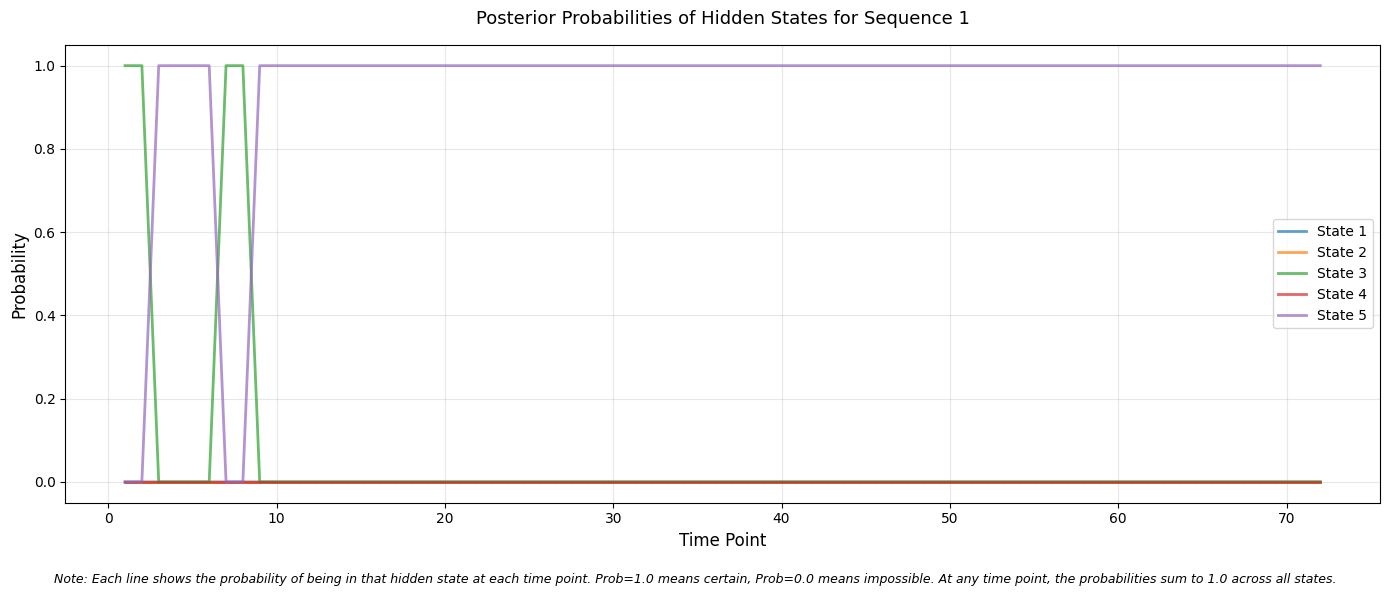


Note: This visualization is only for Sequence 1 as an example. 
Posterior probabilities have been computed for all 712 sequences.
You can modify 'sequence_id' in the code above to visualize a different sequence.


In [10]:
# Get posterior probabilities for all sequences
# This gives us the probability of each hidden state at each time point
posterior_df = posterior_probs(hmm)

# posterior_df is a DataFrame with columns: 'id', 'time', 'state', 'probability'
print("Posterior probabilities DataFrame structure:")
print("=" * 70)
print(f"Total rows: {len(posterior_df)}")
print(f"Columns: {list(posterior_df.columns)}")
print(f"Number of unique sequences: {posterior_df['id'].nunique()}")
print(f"Number of hidden states: {posterior_df['state'].nunique()}")
print("\nFirst few rows:")
print(posterior_df.head(10))

# Look at posterior probabilities for the first sequence
print("\n" + "=" * 70)
print("Posterior probabilities for first sequence (first 10 time points):")
print("=" * 70)
seq_0 = posterior_df[posterior_df['id'] == 0].copy()
seq_0_pivot = seq_0.pivot(index='time', columns='state', values='probability')
seq_0_pivot.columns = [f"State {int(col)+1}" for col in seq_0_pivot.columns]
seq_0_pivot.index.name = 'Time'
print(seq_0_pivot.head(10).round(3))

# Visualize posterior probabilities for one sequence
sequence_id = 0  # First sequence
fig, ax = plt.subplots(figsize=(14, 6))

seq_probs = posterior_df[posterior_df['id'] == sequence_id].copy()
for state in range(hmm.n_states):
    state_data = seq_probs[seq_probs['state'] == state].sort_values('time')
    ax.plot(state_data['time'], state_data['probability'], 
            label=f'State {state+1}', alpha=0.7, linewidth=2)

ax.set_xlabel('Time Point', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_title(f'Posterior Probabilities of Hidden States for Sequence {sequence_id+1}', 
            fontsize=13, pad=15)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

# Add explanatory text
fig.text(0.5, 0.02, 
         'Note: Each line shows the probability of being in that hidden state at each time point. '
         'Prob=1.0 means certain, Prob=0.0 means impossible. '
         'At any time point, the probabilities sum to 1.0 across all states.',
         ha='center', fontsize=9, style='italic')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

print(f"\nNote: This visualization is only for Sequence {sequence_id+1} as an example. ")
print(f"Posterior probabilities have been computed for all {n_sequences} sequences.")
print(f"You can modify 'sequence_id' in the code above to visualize a different sequence.")

## Step 8: Visualize the Model

Let's create visualizations to better understand our HMM model. This matches the visualization capabilities of the R seqHMM package.

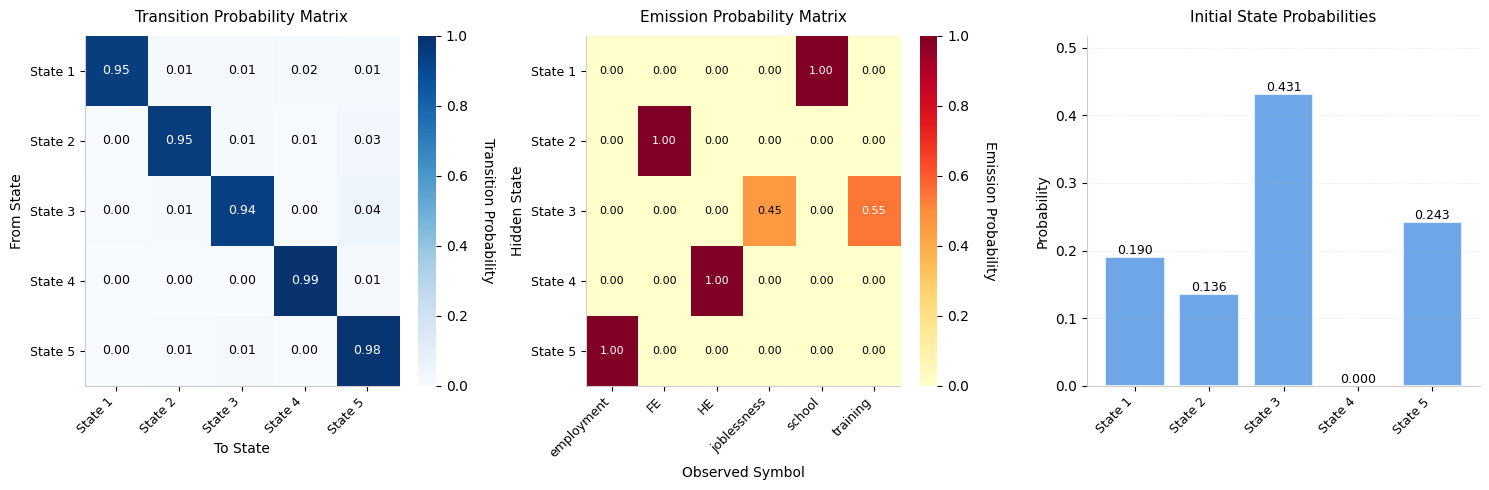

In [11]:
# Plot all components of the HMM
plot_hmm(hmm, which='all', figsize=(15, 5))
plt.tight_layout()
plt.show()

## Step 9: Model Comparison

How do we know if 5 hidden states is the right number? Let's try different numbers of states and compare them using AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion). Lower values are better.

In [ ]:
# Try different numbers of hidden states
n_states_list = [3, 4, 5, 6]
models = {}

print("Fitting models with different numbers of states...")
print("=" * 60)

for n_states in n_states_list:
    print(f"\nFitting model with {n_states} hidden states...")
    
    # Build and fit model
    model = build_hmm(sequence_data, n_states=n_states, random_state=21)
    model = fit_model(model, n_iter=50, tol=5e-2, verbose=False)
    
    # Store model
    models[f'{n_states}_states'] = model
    
    # Calculate AIC and BIC
    model_aic = aic(model)
    model_bic = bic(model)
    
    print(f"  Log-likelihood: {model.log_likelihood:.2f}")
    print(f"  AIC: {model_aic:.2f}")
    print(f"  BIC: {model_bic:.2f}")

print("\n" + "=" * 60)
print("Model Comparison Summary:")
print("=" * 60)

# Compare models using BIC (lower is better)
comparison = compare_models(list(models.values()), criterion='BIC')
print(f"\nBest model according to BIC: {comparison['best_model']}")
print(f"\nDetailed comparison:")
for name, model in models.items():
    print(f"{name:15s} - AIC: {aic(model):10.2f}, BIC: {bic(model):10.2f}")

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

aic_values = [aic(model) for model in models.values()]
bic_values = [bic(model) for model in models.values()]

# Left plot: AIC
ax1.plot(n_states_list, aic_values, 'o-', linewidth=2.5, markersize=10, 
         color='#4A90E2', markerfacecolor='white', markeredgewidth=2.5,
         markeredgecolor='#4A90E2', label='AIC', alpha=0.9)
ax1.set_xlabel('Number of Hidden States', fontsize=11, weight='medium')
ax1.set_ylabel('AIC', fontsize=11, weight='medium')
ax1.set_title('AIC by Number of States', fontsize=12, pad=12, weight='medium')
ax1.grid(True, alpha=0.2, linestyle='--', linewidth=0.8)
ax1.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=10)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_color('#cccccc')
ax1.spines['left'].set_color('#cccccc')

# Right plot: BIC
ax2.plot(n_states_list, bic_values, 's-', linewidth=2.5, markersize=10,
         color='#F5A623', markerfacecolor='white', markeredgewidth=2.5,
         markeredgecolor='#F5A623', label='BIC', alpha=0.9)
ax2.set_xlabel('Number of Hidden States', fontsize=11, weight='medium')
ax2.set_ylabel('BIC', fontsize=11, weight='medium')
ax2.set_title('BIC by Number of States', fontsize=12, pad=12, weight='medium')
ax2.grid(True, alpha=0.2, linestyle='--', linewidth=0.8)
ax2.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_color('#cccccc')
ax2.spines['left'].set_color('#cccccc')

plt.tight_layout()
plt.show()

Fitting models with different numbers of states...

Fitting model with 3 hidden states...


## Step 10: Mixture HMM (Clustering Sequences)

A **Mixture HMM (MHMM)** extends the basic HMM by allowing different groups (clusters) of sequences, each with their own HMM pattern. This is useful when you suspect there are different types of sequences in your data.

For example, we might discover:
- Cluster 1: "Education-focused" group
- Cluster 2: "Employment-focused" group
- Cluster 3: "Mixed transitions" group

In [ ]:
# Build a Mixture HMM with 3 clusters
# Each cluster will have its own HMM with 5 hidden states
print("Building Mixture HMM...")
mhmm = build_mhmm(
    sequence_data,
    n_clusters=3,      # Number of clusters/groups
    n_states=5,        # Number of hidden states per cluster
    random_state=21     # Matching R's set.seed(21)
)

print(f"MHMM created with {mhmm.n_clusters} clusters and {mhmm.n_states} states per cluster")

Building Mixture HMM...
MHMM created with 3 clusters and [5, 5, 5] states per cluster


In [ ]:
# Fit the Mixture HMM
# This may take longer than a basic HMM

# Suppress hmmlearn warnings about init_params
# These warnings occur because hmmlearn checks init_params before fitting,
# but the parameters are actually correctly set before the fit() call
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='.*init_params.*')
    warnings.filterwarnings('ignore', message='.*overwritten during initialization.*')

    print("Fitting Mixture HMM (this may take a few minutes)...")
    mhmm = fit_mhmm(
        mhmm,
        n_iter=100,
        verbose=True
    )

print("\nMixture HMM fitting completed!")
print(f"Log-likelihood: {mhmm.log_likelihood:.2f}")
print(f"Number of iterations: {mhmm.n_iter}")

Fitting Mixture HMM (this may take a few minutes)...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 1: log-likelihood = -15049.8222


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 2: log-likelihood = -16370.7696


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 3: log-likelihood = -13919.6465


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 4: log-likelihood = -15640.3919


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 5: log-likelihood = -15717.5669


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 6: log-likelihood = -16000.6431


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 7: log-likelihood = -16365.0304


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 8: log-likelihood = -13773.8190


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 9: log-likelihood = -14902.7302


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 10: log-likelihood = -16394.4059


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 11: log-likelihood = -14556.5870


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 12: log-likelihood = -14706.2084


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 13: log-likelihood = -13792.0783


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 14: log-likelihood = -13488.0395


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 15: log-likelihood = -16037.0702


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 16: log-likelihood = -14920.3338


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 17: log-likelihood = -16166.8673


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 18: log-likelihood = -15244.8080


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 19: log-likelihood = -16393.6193


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 20: log-likelihood = -14920.9088


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 21: log-likelihood = -13837.0598


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 22: log-likelihood = -16393.6158


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 23: log-likelihood = -16346.4392


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 24: log-likelihood = -16364.9208


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 25: log-likelihood = -16016.8010


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 26: log-likelihood = -16384.3425


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 27: log-likelihood = -15245.8601


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 28: log-likelihood = -16122.4062


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 29: log-likelihood = -16310.0931


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 30: log-likelihood = -16313.1657


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 31: log-likelihood = -16394.4042


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 32: log-likelihood = -16362.6736


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 33: log-likelihood = -16262.7865


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 34: log-likelihood = -13715.0789


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 35: log-likelihood = -16394.3837


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 36: log-likelihood = -16369.6604


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 37: log-likelihood = -16393.0638


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 38: log-likelihood = -15038.2091


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 39: log-likelihood = -14587.6855


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 40: log-likelihood = -14901.1384


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 41: log-likelihood = -13747.2540


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 42: log-likelihood = -13740.2741


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 43: log-likelihood = -16195.8029


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 44: log-likelihood = -13476.7506


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 45: log-likelihood = -15983.3282


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 46: log-likelihood = -16365.2828


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 47: log-likelihood = -15129.7622


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 48: log-likelihood = -14992.6474


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 49: log-likelihood = -16394.4058


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 50: log-likelihood = -16384.7625


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 51: log-likelihood = -16394.4058


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 52: log-likelihood = -16350.6573


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 53: log-likelihood = -16117.3491


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 54: log-likelihood = -14953.0780


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 55: log-likelihood = -16384.5992


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 56: log-likelihood = -14845.6817


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 57: log-likelihood = -16216.3464


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 58: log-likelihood = -15128.8665


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 59: log-likelihood = -16019.5287


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 60: log-likelihood = -16393.2639


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

In [ ]:
# Predict which cluster each sequence belongs to
cluster_assignments = predict_mhmm(mhmm)

print(f"Cluster assignments shape: {cluster_assignments.shape}")
print(f"\nCluster distribution:")
print("=" * 50)
unique, counts = np.unique(cluster_assignments, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster+1}: {count} sequences ({count/len(cluster_assignments)*100:.1f}%)")

# Add cluster assignments to original dataframe for analysis
df_with_clusters = df.copy()
df_with_clusters['cluster'] = cluster_assignments + 1  # 1-indexed for readability

print("\nFirst few sequences with cluster assignments:")
print(df_with_clusters[['id', 'cluster']].head(10))

In [ ]:
# Visualize the Mixture HMM
plot_mhmm(mhmm, which='all', figsize=(18, 6))
plt.tight_layout()
plt.show()

## Step 11: Understanding the Results

Let's examine what each cluster represents by looking at the cluster probabilities and the HMM parameters for each cluster.

In [ ]:
# Cluster probabilities (how likely each sequence is to belong to each cluster)
print("Cluster Probabilities:")
print("=" * 50)
for i in range(mhmm.n_clusters):
    prob = mhmm.cluster_probs[i]
    print(f"Cluster {i+1}: {prob:.4f} ({prob*100:.2f}% of sequences)")

# Look at emission probabilities for each cluster
print("\nEmission Probabilities by Cluster:")
print("=" * 50)
for cluster_idx in range(mhmm.n_clusters):
    print(f"\nCluster {cluster_idx + 1}:")
    emission_probs = mhmm.models[cluster_idx].emission_probs
    emission_df = pd.DataFrame(
        emission_probs,
        index=[f"Hidden State {i+1}" for i in range(mhmm.n_states)],
        columns=[f"{labels[i]}" for i in range(len(labels))]
    )
    print(emission_df.round(3))
    print()

# Summary

Congratulations! You've completed a comprehensive tutorial on Hidden Markov Models with Sequenzo, following the same approach as the seqHMM R package.

## What We Learned:

1. **Data Preparation**: How to load and prepare sequence data using `SequenceData`
2. **Basic HMM**: How to build and fit a basic Hidden Markov Model (matching R's seqHMM)
3. **Model Fitting**: Using the EM algorithm to estimate model parameters
4. **Prediction**: Predicting hidden states using the Viterbi algorithm
5. **Posterior Probabilities**: Getting probability distributions over hidden states
6. **Visualization**: Creating plots to understand model parameters
7. **Model Comparison**: Using AIC and BIC to select the best model
8. **Mixture HMM**: Extending HMM to discover clusters of sequences

## Key Takeaways:

- **Hidden States** represent underlying patterns in your sequences
- **Transition Probabilities** show how sequences move between hidden states
- **Emission Probabilities** show which observed states each hidden state produces
- **Model Selection** is important - try different numbers of states and compare
- **Mixture HMM** can discover different groups of sequences with distinct patterns

## Comparison with R seqHMM:

This tutorial follows the same methodology as the seqHMM R package:

- Uses the same dataset (mvad)
- Uses the same number of hidden states (5 for basic HMM)
- Uses the same random seed (21) for reproducibility
- Follows the same workflow: build → fit → predict → visualize
- Does NOT use weighted data (as requested)

You can compare the results step-by-step with the R code to verify consistency.

## Next Steps:

- Try different numbers of hidden states and clusters
- Explore Non-homogeneous HMM (NHMM) if you have covariates
- Use bootstrap methods to get confidence intervals
- Apply these methods to your own sequence data!

## Additional Resources:

- See `sequenzo/seqhmm/README.md` for more detailed documentation
- Check out other tutorials in the `Tutorials/` directory
- Refer to the seqHMM R package documentation for methodology details

### Network Graph Visualization (Similar to R's plot.hmm)

The network graph visualization shows the HMM model as a directed graph where:
- **Nodes (circles)**: Each node represents a hidden state, displayed as a pie chart showing the emission probabilities (which observed states each hidden state is likely to produce)
- **Edges (arrows)**: Each arrow represents a transition between states, with the thickness and label showing the transition probability
- **Node labels**: Show the initial probability of each state (or state names)
- **Legend**: Shows what each color in the pie charts represents (the observed states)

This visualization is very similar to R's `plot.hmm()` function and helps you understand the structure and flow of your HMM model at a glance.